# **XGBoost** #



## **Step 1 – Load the Data** ## 

In this step, we load the preprocessed CSV dataset into a pandas DataFrameWe also perform a basic inspection to ensure the structure is correct and there are no missing values. This ensures the dataset is ready for splitting and modeling in the next steps.

In [21]:
import pandas as pd

# Load the dataset
df = pd.read_csv("Fraud_Subset_50_50_10k_each.csv")

# Display first few rows
df.head()


,fraud,trustLevel,totalScanTimeInSeconds,lineItemVoids,quantityModification,grandTotal,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,scansWithoutRegistration
0,1,1,1639,9,2,92.58,0.018304,0.056486,0.300000,10
1,1,2,1356,4,3,18.99,0.022124,0.014004,0.133333,8
2,1,1,1111,5,5,63.75,0.027003,0.057381,0.166667,5
3,1,1,887,8,0,79.47,0.029312,0.089594,0.307692,8
4,1,1,1601,7,1,39.81,0.016240,0.024866,0.269231,1


In [38]:
# Check for basic structure and null values
df.info()

# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Preview the distribution of the target variable
print("\nTarget variable distribution:")
print(df['fraud'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   fraud                      20000 non-null  int64  
 1   trustLevel                 20000 non-null  int64  
 2   totalScanTimeInSeconds     20000 non-null  int64  
 3   lineItemVoids              20000 non-null  int64  
 4   quantityModification       20000 non-null  int64  
 5   grandTotal                 20000 non-null  float64
 6   scannedLineItemsPerSecond  20000 non-null  float64
 7   valuePerSecond             20000 non-null  float64
 8   lineItemVoidsPerPosition   20000 non-null  float64
 9   scansWithoutRegistration   20000 non-null  int64  
dtypes: float64(4), int64(6)
memory usage: 1.5 MB
Missing values per column:
fraud                        0
trustLevel                   0
totalScanTimeInSeconds       0
lineItemVoids                0
quantityModificati

## **Step 2 – Exploratory Data Analysis (EDA)** ##

Before we started building the model, we first took a close look at the dataset to better understand what kind of information it contains and whether anything needed to be changed or removed. This kind of analysis is called Exploratory Data Analysis (EDA), and it helps us make better decisions for the rest of the project.

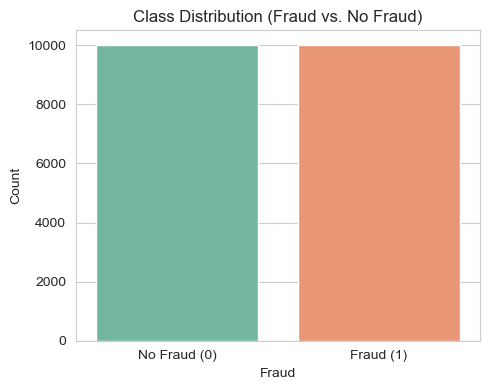

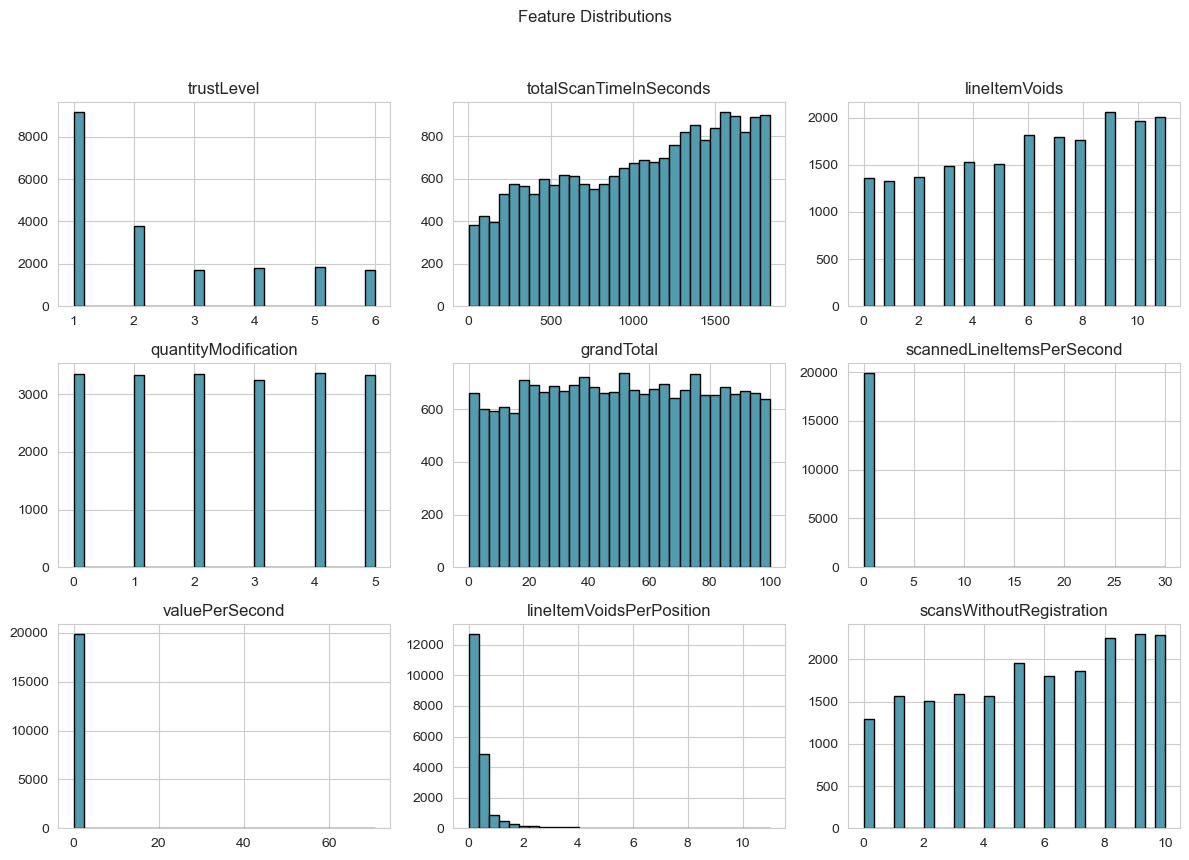

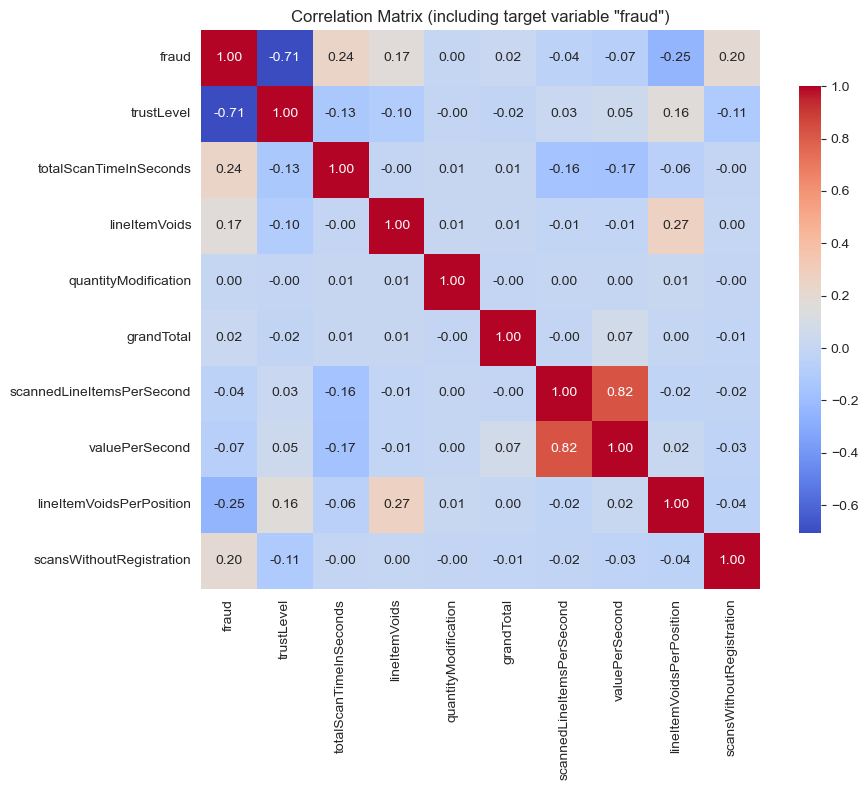

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Reload the dataset (if not already loaded)
df = pd.read_csv("Fraud_Subset_50_50_10k_each.csv")

# Create a copy for EDA
eda_df = df.copy()

# 1. Plot class distribution
plt.figure(figsize=(5, 4))
sns.countplot(data=eda_df, x='fraud', hue='fraud', palette='Set2', legend=False)
plt.title('Class Distribution (Fraud vs. No Fraud)')
plt.xlabel('Fraud')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Fraud (0)', 'Fraud (1)'])
plt.tight_layout()
plt.show()

# 2. Plot histograms for selected numerical features
numerical_features = eda_df.drop(columns='fraud').columns

eda_df[numerical_features].hist(
    bins=30, figsize=(12, 9), layout=(3, 3), 
    color='#539caf', edgecolor='black'
)
plt.suptitle('Feature Distributions')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 3. Correlation matrix (including target)
plt.figure(figsize=(10, 8))
corr = eda_df.corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix (including target variable "fraud")')
plt.tight_layout()
plt.show()


**Class Distribution**

We checked how many transactions in the dataset were marked as fraud and how many were not. The result was very clear: the dataset is perfectly balanced, with 10,000 fraudulent and 10'000 non-fraudulent cases. This is great for training models, because it means we don’t have to make any adjustments to fix an imbalance. A balanced dataset allows us to use standard evaluation metrics like precision and recall without worrying that the model will favor one class over the other.

**Feature Distributions**

Next, we looked at how each of the input features is distributed. We created histograms for all 9 features. Some of them had values spread out across a wide range, while others were more concentrated or skewed. Importantly, none of the features were constant or showed signs of being unhelpful. Since our model (XGBoost) doesn’t need the data to be scaled or normalized, we didn’t need to apply any transformations. We simply used the features as they are.

**Correlation Analysis**

We also looked at how strongly the features are related to each other by calculating a correlation matrix. If two features are almost identical, it can confuse some types of models. But in our case, no pair of features had a very strong correlation (like above 0.9), so there were no problems with multicollinearity. Some features were moderately related to the target variable fraud, which is a good sign that they can help the model make accurate predictions.

## **Step 3 – Feature and Target Separation** ##

In this step, we split the dataset into:

- Features (X): all input variables used for prediction.

- Target (y): the label we want to predict — in this case, whether a transaction is fraudulent (fraud = 1) or not (fraud = 0).

Separating X and y is a standard and necessary step before model training and evaluation.

In [23]:
# Define target variable
y = df['fraud']

# Define features (all columns except 'fraud')
X = df.drop(columns=['fraud'])

# Check the shape of feature and target sets
print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)


Feature matrix shape: (20000, 9)
Target vector shape: (20000,)


## **Step 4 – Stratified Train-Test Split** ##

We split our dataset into training and testing sets using stratified sampling. Stratification ensures that the class distribution (fraud vs. non-fraud) in the target variable is preserved in both splits. This is essential in classification tasks, especially when class imbalance exists. Even if in our case the dataset is currently balanced (50/50), it's still good practice.

In [28]:
from sklearn.model_selection import train_test_split

# Perform stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Output the shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train distribution:\n", y_train.value_counts(normalize=True))
print("y_test distribution:\n", y_test.value_counts(normalize=True))


X_train shape: (16000, 9)
X_test shape: (4000, 9)
y_train distribution:
 fraud
1    0.5
0    0.5
Name: proportion, dtype: float64
y_test distribution:
 fraud
1    0.5
0    0.5
Name: proportion, dtype: float64


## **Step 5 – Initialize and Train the XGBoost Model (Baseline)** ##

In this step, we initialize the XGBClassifier with basic settings (default hyperparameters). This baseline model helps to understand how well XGBoost performs without tuning. Later, we will improve it using cross-validation and hyperparameter optimization.

In [30]:
from xgboost import XGBClassifier

# Initialize the model (no need for use_label_encoder)
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict
y_pred = xgb_model.predict(X_test)


## **Step 6 – Cross-Validation and Evaluation (Baseline Metrics)** ##

Before tuning the model, we want to evaluate how well it performs using cross-validation. Cross-validation gives us a more reliable estimate of model performance than a single train/test split. We’ll use Stratified K-Fold to maintain class balance in each fold.

We also evaluate multiple classification metrics:

- Accuracy
- Precision
- Recall
- F1 Score
- ROC-AUC
- Matthews Correlation Coefficient (MCC)





In [31]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, matthews_corrcoef, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'mcc': make_scorer(matthews_corrcoef)
}

# Create stratified K-fold object
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Run cross-validation
cv_results = cross_validate(
    estimator=xgb_model,
    X=X,
    y=y,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)

# Display average scores
print("Average cross-validation results (5-fold):")
for metric in scoring.keys():
    print(f"{metric}: {np.mean(cv_results[f'test_{metric}']):.4f}")

Average cross-validation results (5-fold):
accuracy: 0.9885
precision: 0.9784
recall: 0.9991
f1: 0.9886
roc_auc: 0.9993
mcc: 0.9772


## **Step 7 – Feature Importance Analysis** ##

In this step, we examine which features the XGBoost model considers most important when making predictions. This helps us:

- Understand which variables drive the model
- Justify our model decisions in the documentation
- Potentially simplify the model by removing low-impact features

XGBoost provides built-in feature importance scores, which can be visualized to make interpretation easier.

<Figure size 1000x600 with 0 Axes>

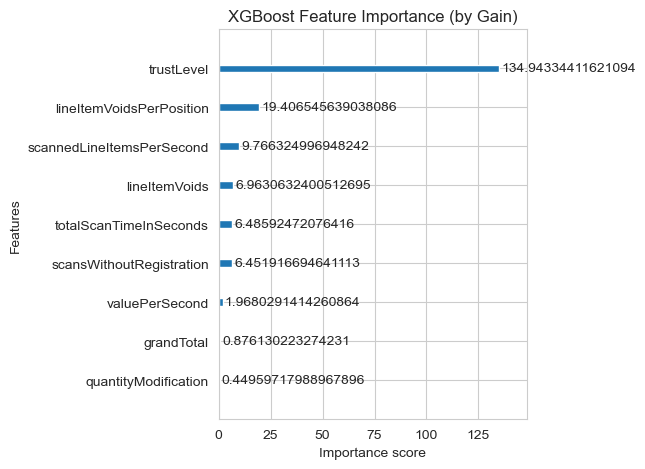

In [32]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# (Re-)train model on the full dataset to get overall feature importance
xgb_model.fit(X, y)

# Plot feature importance (default: 'weight')
plt.figure(figsize=(10, 6))
plot_importance(xgb_model, importance_type='gain', max_num_features=9)
plt.title("XGBoost Feature Importance (by Gain)")
plt.tight_layout()
plt.show()


## **Step 8 – Hyperparameter Tuning with RandomizedSearchCV** ##

In this step, we optimize the most important hyperparameters of the XGBoost model using RandomizedSearchCV. Compared to GridSearchCV, this approach is more efficient because it samples combinations randomly rather than testing all possible ones.

We’ll focus on the most impactful parameters for model performance and overfitting control.

In [33]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 4, 5, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_lambda': [1, 5, 10]  # L2 regularization
}

# Initialize classifier
xgb_clf = XGBClassifier(eval_metric='logloss', random_state=42)

# Set up randomized search with 5-fold CV
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_grid,
    scoring='f1',
    n_iter=30,  # Number of combinations to try
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Run hyperparameter tuning
random_search.fit(X_train, y_train)

# Show best parameters
print("Best parameters found:")
print(random_search.best_params_)

# Best estimator
best_model = random_search.best_estimator_


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters found:
{'subsample': 0.8, 'reg_lambda': 5, 'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 1, 'colsample_bytree': 1.0}


After running a randomized hyperparameter search with 30 different parameter combinations using 5-fold cross-validation, the best-performing configuration, measured by the F1 score, are seen above.

This result suggests that the most effective model setup builds 400 shallow trees (maximum depth of 3), using 80% of the training data per tree (subsample=0.8) and all features (colsample_bytree=1.0). It uses moderate regularization (reg_lambda=5, gamma=1) to reduce overfitting, and a learning rate of 0.2 to balance training speed and stability. Overall, this configuration strikes a good balance between model complexity and generalization, making it well-suited for the fraud detection task.

## **Step 9 – Final Training and Evaluation with the Tuned Model** ##

In this step, we take the best model (from Step 7) and:

Train it on the entire training set (X_train, y_train)

Use it to predict fraud on the test set

Evaluate its performance using all key metrics:

- Accuracy
- Precision
- Recall
- F1 Score
- ROC-AUC
- Matthews Correlation Coefficient (MCC)
- Confusion Matrix

This gives us a realistic picture of how well the model performs on unseen data.

,Score
Accuracy,0.9915
Precision,0.9833
Recall,1.0000
F1 Score,0.9916
ROC AUC,0.9915
MCC,0.9831


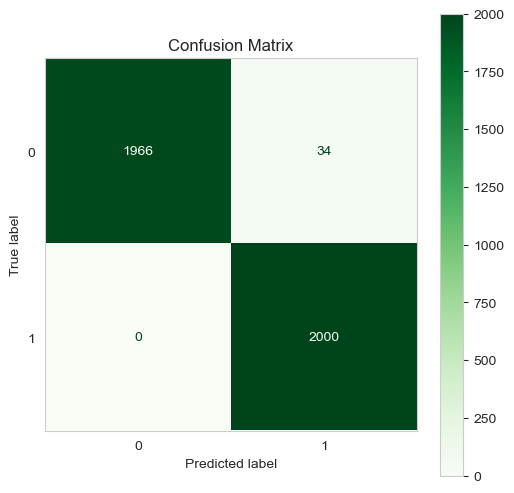

In [37]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Train the best model on the full training set
best_model.fit(X_train, y_train)

# Predict on the test set
y_pred = best_model.predict(X_test)

# Compute evaluation metrics
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_pred),
    'MCC': matthews_corrcoef(y_test, y_pred)
}

# Format and display metrics as a DataFrame
metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Score'])
metrics_df = metrics_df.round(4)
display(metrics_df)

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)

plt.figure(figsize=(6, 6))
disp.plot(cmap='Greens', values_format='d', ax=plt.gca())
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


**Metrics**

Accuracy (99.15%): The model made the correct prediction in over 99% of all test cases.

Precision (98.33%): Of all the cases the model predicted as fraud, 98.33% were actually fraud.
This means very few honest customers were falsely accused.

Recall (100%): The model found all fraud cases in the test set. It didn't miss any.
This is especially important in fraud detection, where missing a fraud can be costly.

F1 Score (99.16%): This metric balances precision and recall. A high F1 score confirms that the model is performing well in both detecting fraud and avoiding false alarms.

ROC AUC (99.15%): This tells us how well the model separates fraud from non-fraud across all threshold levels. A value close to 1.0 means excellent separation.

MCC (0.9831): The Matthews Correlation Coefficient is a very strong score here, confirming the model performs well across all four parts of the confusion matrix.


**Confusion Matrix**

1'966 legitimate customers were correctly identified as non-fraud.

2'000 fraudulent customers were all correctly identified — no fraud cases were missed.

Only 34 legitimate cases were mistakenly flagged as fraud.


**Summary**

The final model performs exceptionally well in detecting fraudulent transactions while minimizing errors. It was able to correctly identify all fraud cases in the test set (recall = 100%), which is crucial in this context, since missing fraudulent behavior could lead to direct financial losses. At the same time, the model maintains a high precision of 98.33%, meaning that only a small number of legitimate customers were wrongly flagged as fraudulent. This balance is also reflected in the F1 score of 99.16%, confirming that the model performs strongly on both detection and correctness.

The overall accuracy of 99.15% indicates that the model rarely makes mistakes, and the ROC AUC score of 99.15% shows that it can clearly separate fraud from non-fraud cases. The Matthews Correlation Coefficient (MCC), a more conservative metric that accounts for all four outcomes in the confusion matrix, is also very high (0.9831), supporting the conclusion that the model is stable and trustworthy.

With these results, we can conclude that the final XGBoost model is highly effective for fraud detection. It combines sensitivity (detecting all fraudulent behavior) with precision (keeping false accusations low), making it suitable for real-world applications where both security and customer trust are essential.



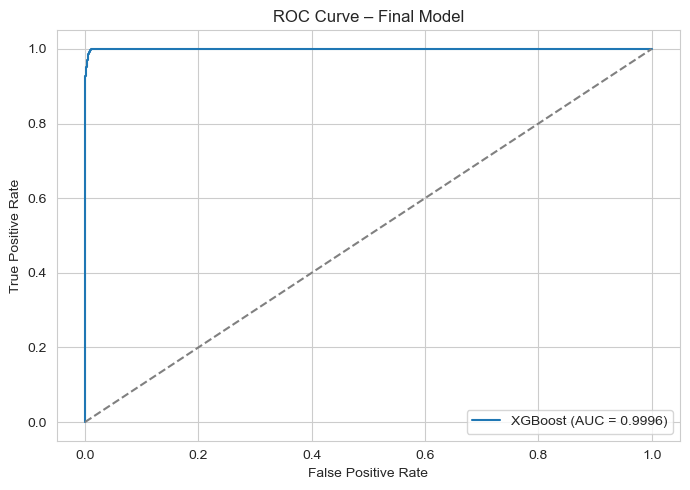

In [40]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class (fraud = 1)
y_probs = best_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal = random model
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Final Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

The ROC Curve shows the model's ability to distinguish between fraud and non-fraud cases across all classification thresholds. An AUC value close to 1.0 indicates strong performance.

<Figure size 1000x600 with 0 Axes>

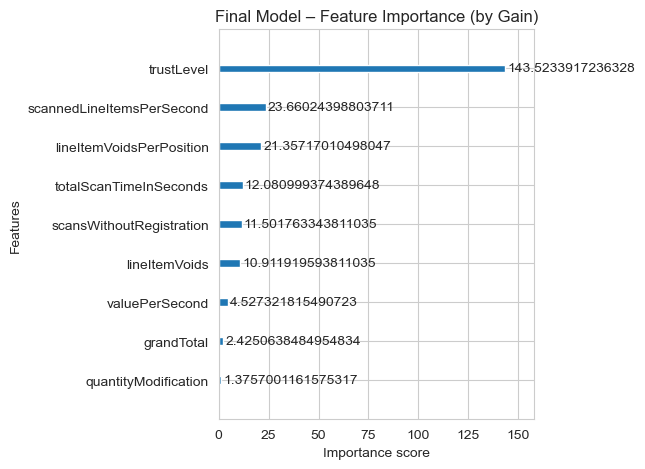

In [41]:
# Plot feature importance from the final tuned model
plt.figure(figsize=(10, 6))
plot_importance(best_model, importance_type='gain', max_num_features=9)
plt.title("Final Model – Feature Importance (by Gain)")
plt.tight_layout()
plt.show()


Additionally, we re-examined feature importance in the final tuned model. While all 9 features were included, only a few contributed significantly to the model’s decision-making, confirming the results seen earlier with the baseline model.